In [1]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Normalization, RandomFlip, RandomRotation

from utils.data_loader import DataLoader

In [2]:
data_loader = DataLoader('split_data_white_padded')

train_data_path = '/train'
test_data_path = '/test'
validation_data_path = '/validation'

IMAGE_SIZE = 256
BATCH_SIZE = 32
SHUFFLE = True

train_dataset = data_loader.load_image_data(train_data_path, IMAGE_SIZE, BATCH_SIZE, SHUFFLE)
validation_dataset = data_loader.load_image_data(validation_data_path, IMAGE_SIZE, BATCH_SIZE, not SHUFFLE)
test_dataset = data_loader.load_image_data(test_data_path, IMAGE_SIZE, BATCH_SIZE, not SHUFFLE)

Found 4121 files belonging to 2 classes.
Found 1152 files belonging to 2 classes.
Found 577 files belonging to 2 classes.


In [3]:
normalization = Normalization(axis=None)

# calculate mean and standard deviation over all training samples and normalize all data
train_images = train_dataset.map(lambda x, y: x)
normalization.adapt(train_images)

In [4]:
data_augmentation = Sequential()
data_augmentation.add(RandomFlip("horizontal"))
data_augmentation.add(RandomRotation(0.1))

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(dataset, augment=False):
  # Resize and rescale all datasets.
  dataset = dataset.map(lambda x, y: (normalization(x), y), 
              num_parallel_calls=AUTOTUNE)

  # Use data augmentation only on the training set.
  if augment:
    dataset = dataset.map(lambda x, y: (data_augmentation(x), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
train_dataset = preprocess(train_dataset, augment=True)
validation_dataset = preprocess(validation_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0], shape=(32,), dtype=int32)


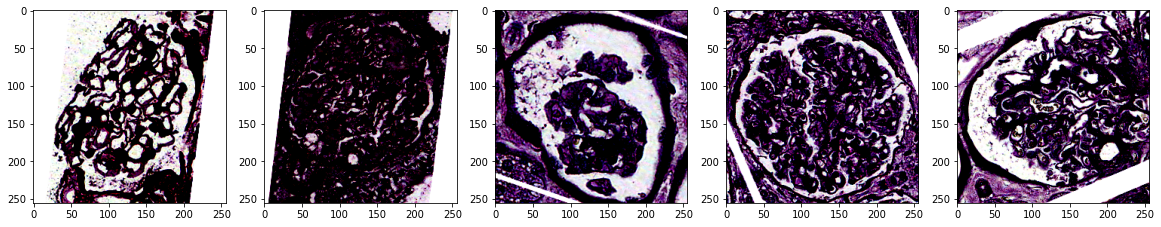

In [7]:
def display(ds):
    images, labels = next(iter(ds.take(5)))
    print(labels)
    fig, ax = plt.subplots(ncols=5, figsize=(20,20))
    for idx, img in enumerate(images[:5]):
        ax[idx].imshow(img.numpy())

display(train_dataset)

In [8]:
simple_cnn_model = Sequential()

simple_cnn_model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
simple_cnn_model.add(MaxPooling2D())
simple_cnn_model.add(Conv2D(32, (3,3), 1, activation='relu'))
simple_cnn_model.add(MaxPooling2D())
simple_cnn_model.add(Conv2D(16, (3,3), 1, activation='relu'))
simple_cnn_model.add(MaxPooling2D())
simple_cnn_model.add(Flatten())
simple_cnn_model.add(Dense(256, activation='relu'))
simple_cnn_model.add(Dense(1, activation='sigmoid'))

In [9]:
optimizer = Adam(learning_rate=0.0001)

simple_cnn_model.compile(optimizer=optimizer, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [10]:
simple_cnn_history = simple_cnn_model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20


129/129 [==============================] - 51s 377ms/step - loss: 0.3283 - accuracy: 0.8694 - val_loss: 0.2426 - val_accuracy: 0.9028
Epoch 2/20
129/129 [==============================] - 63s 474ms/step - loss: 0.2068 - accuracy: 0.9223 - val_loss: 0.1899 - val_accuracy: 0.9306
Epoch 3/20
129/129 [==============================] - 64s 481ms/step - loss: 0.1897 - accuracy: 0.9260 - val_loss: 0.1734 - val_accuracy: 0.9384
Epoch 4/20
129/129 [==============================] - 65s 492ms/step - loss: 0.1655 - accuracy: 0.9376 - val_loss: 0.3310 - val_accuracy: 0.8854
Epoch 5/20
129/129 [==============================] - 69s 522ms/step - loss: 0.1680 - accuracy: 0.9369 - val_loss: 0.1466 - val_accuracy: 0.9462
Epoch 6/20
129/129 [==============================] - 74s 551ms/step - loss: 0.1487 - accuracy: 0.9408 - val_loss: 0.1415 - val_accuracy: 0.9505
Epoch 7/20
129/129 [==============================] - 73s 551ms/step - loss: 0.1337 - accuracy: 0.9503 - val_loss: 0.1383 - val_

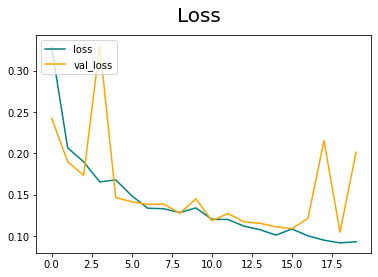

In [11]:
fig = plt.figure()
plt.plot(simple_cnn_history.history['loss'], color='teal', label='loss')
plt.plot(simple_cnn_history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

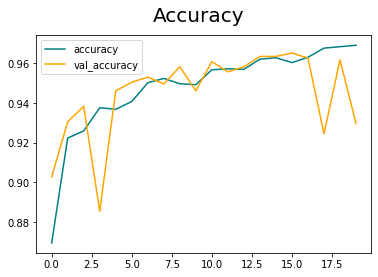

In [12]:
fig = plt.figure()
plt.plot(simple_cnn_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(simple_cnn_history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [13]:
test_dataset_normalized = preprocess(test_dataset)

19/19 [==============================] - 3s 158ms/step - loss: 0.2116 - accuracy: 0.9324
Test accuracy: 0.9324089884757996
19/19 [==============================] - 3s 143ms/step


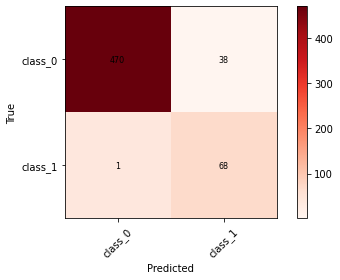

In [15]:
# Evaluate the model
loss, accuracy = simple_cnn_model.evaluate(test_dataset_normalized)
print("Test accuracy:", accuracy)

# Generate predictions for confusion matrix
y_pred = simple_cnn_model.predict(test_dataset_normalized)
y_pred_classes = tf.where(y_pred > 0.5, 1, 0)
y_true = tf.concat([y for _, y in test_dataset], axis=0)

# Calculate and plot confusion matrix
cm = tf.math.confusion_matrix(y_true, y_pred_classes)
# Annotate each cell with the corresponding value

plt.imshow(cm, cmap=plt.cm.Reds)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(test_dataset.class_names)), test_dataset.class_names, rotation=45)
plt.yticks(range(len(test_dataset.class_names)), test_dataset.class_names)
plt.colorbar()
for i in range(len(cm)):
    for j in range(len(cm)):
        value = cm[i, j].numpy()
        plt.text(i, j, value, ha='center', va='center', fontsize=8)
plt.tight_layout()
plt.show()